# Peer-graded Assignment: DTSA 5510 Unsupervised Algorithms in Machine Learning Final Project

## Classification of Pneumonia

### Tung Anh Nguyen Sy, 4/19/2023
### Github repository: https://github.com/tanh3ka/tanh3ka-Master-of-Science-in-Data-Science-5510/

Goals:
1. Data cleaning
2. Image size reducing
3. EDA
4. Unsupervised model building
5. Compare with supervised model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import os
import math
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import itertools
import random

In [2]:
%cd "C:/Users/Admin/Desktop/WorkProjects/master5510/CellData/chest_xray"

os.listdir()

C:\Users\Admin\Desktop\WorkProjects\master5510\CellData\chest_xray


['.DS_Store', 'reducedData.csv', 'test', 'train']

### Dataset:
Dataset consist of images on both chest X-Rays and Optical Coherence Tomography. This dataset can be download at https://data.mendeley.com/datasets/rscbjbr9sj/3
- Train: 
The "train" dataset contains 1.18 GB of chest X-ray data, including 5233 X-rays of normal chests, 1345 X-rays with viral pneumonia, and 2538 X-rays with bacterial pneumonia. 

- Test: 
The "test" dataset contains 105 MB of data, with 235 normal chest X-rays, 626 X-rays with viral pneumonia, and 242 X-rays with bacterial pneumonia. 

In [3]:
# File path
repopath = "./train/" + "NORMAL/"
filepath = repopath + os.listdir(repopath)[0]

# Reads a single image and displays it as a numpy array with dimensions
testpic = cv.imread(filepath, 0)
testpic = cv.resize(testpic, (256, 256))

print(testpic.shape)

(256, 256)


In [4]:
# Function to loads the test and train data and converts them to numpy arrays, which will then be combined
def readXRay(path, pixDesired = 1000, n_imgs = "use all"):
    firstImagePath = path + os.listdir(path)[0]
    firstPic = cv.imread(firstImagePath, 0)
    if pixDesired != None:
        data = cv.resize(firstPic, (pixDesired, pixDesired))
        data = data.reshape(1, pixDesired ** 2)# If performance allows, increase resize!
    else:
        data = data.reshape(1, firstPic.shape[0] * firstPic.shape[1])
    if n_imgs == "use all":
        for img in os.listdir(path)[1:]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired))
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
    else:
        for img in os.listdir(path)[1:n_imgs]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired)) # If performance allows, increase resize!
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
    return(data)

In [5]:
# The data will be loaded in the following order: Normal Train, Viral Train, Bacterial Train, Normal Test, Viral Test, and Bacterial Test

# Repositories path to read data:
paths = ["./train/NORMAL/", "./train/VIRAL/", "./train/BACTERIAL/", "./test/NORMAL/", "./test/VIRAL/", "./test/BACTERIAL/"]

data = readXRay(path = paths[0], pixDesired = 100, n_imgs = "use all")
firstendTime = time.time()
print(data.shape)

for path in paths[1:]:
    startTime = time.time()
    this_data = readXRay(path = path, pixDesired = 100, n_imgs = "use all")
    endTime = time.time()
    print(this_data.shape)
    data = np.append(data, this_data, axis = 0)
    
print(data.shape)

(1349, 10000)
(1345, 10000)
(2538, 10000)
(234, 10000)
(148, 10000)
(242, 10000)
(5856, 10000)


In [6]:
# Records the three class labels
Normal1 = np.asarray(["NORMAL" for i in range(1349)])
Viral1 = np.asarray(["VIRAL" for i in range(1345)])
Bacterial1 = np.asarray(["BACTERIAL" for i in range(2538)])
Normal2 = np.asarray(["NORMAL" for i in range(234)])
Viral2 = np.asarray(["VIRAL" for i in range(148)])
Bacterial2 = np.asarray(["BACTERIAL" for i in range(242)])
labs = np.append(Normal1, Viral1, axis = 0)
labs = np.append(labs, Bacterial1, axis = 0)
labs = np.append(labs, Normal2, axis = 0)
labs = np.append(labs, Viral2, axis = 0)
labs = np.append(labs, Bacterial2, axis = 0)
assert labs.shape[0] == data.shape[0]
print(labs.shape)

(5856,)


In [7]:
# Records the two class labels
Infected1 = np.asarray(["INFECTED" for i in range(1345 + 2538)])
Infected2 = np.asarray(["INFECTED" for i in range(148 + 242)])
labs2 = np.append(Normal1, Infected1, axis = 0)
labs2 = np.append(labs2, Normal2, axis = 0)
labs2 = np.append(labs2, Infected2, axis = 0)
assert labs2.shape[0] == data.shape[0]
print(labs2.shape)

(5856,)


#### Reduce data size

In [8]:
# Apply PCA (Principal Component Analysis) to the data
# Set the minimum explained variance to 0.98 to avoid hindering the ability of our models to accurately categorize the X-Rays
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")
reducedData = pca.fit_transform(data)
print(reducedData.shape)

(5856, 1533)


### EDA

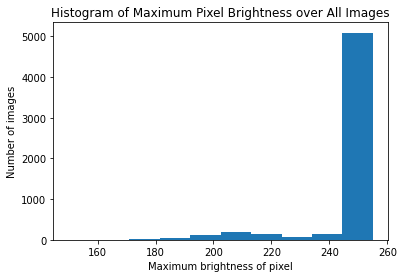

In [9]:
maxes = list(np.max(data, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Pixel Brightness over All Images")
plt.show()

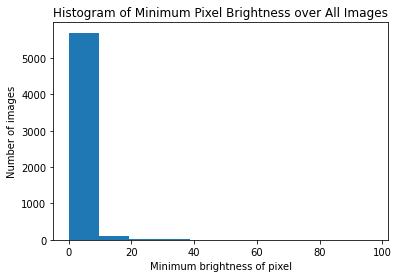

In [10]:
mins = np.min(data, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Pixel Brightness over All Images")
plt.show()

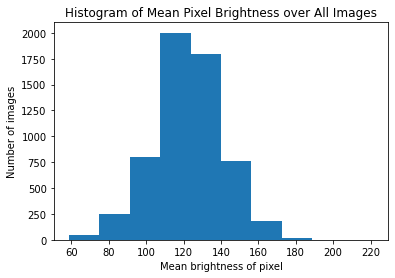

In [11]:
means = np.mean(data, axis = 1)
plt.hist(means)
plt.xlabel("Mean brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Pixel Brightness over All Images")
plt.show()

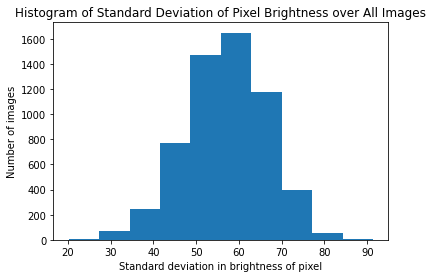

In [12]:
stds = np.std(data, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation in brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Pixel Brightness over All Images")
plt.show()

Create a function to calculate the correlation between any two pixels chosen by user.

In [13]:
# Function to allow user to choose the correlation between two features
def getCorr(data, pix1, pix2):
    pix1vals = data[:, pix1]
    pix1vals = pix1vals.reshape((pix1vals.shape[0], 1))
    pix2vals = data[:, pix2].reshape((pix1vals.shape[0], 1))
    corrdata = np.append(pix1vals, pix2vals, axis = 1)
    corr = np.corrcoef(corrdata, rowvar = False)[0, 1]
    return(corr)
testCorr = getCorr(data, 12, 1223)
print(testCorr)

0.4703225494850951


#### EDA on the reduced dataset after PCA

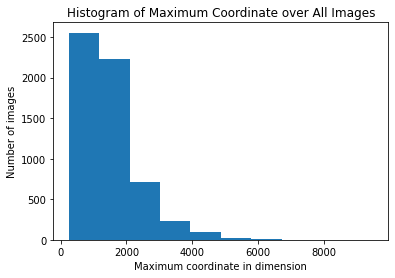

In [14]:
maxes = list(np.max(reducedData, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Coordinate over All Images")
plt.show()

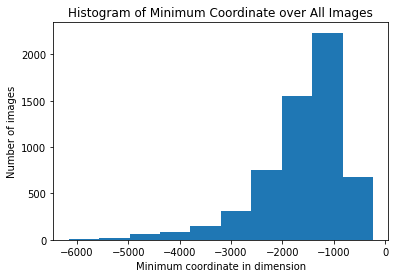

In [15]:
mins = np.min(reducedData, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Coordinate over All Images")
plt.show()

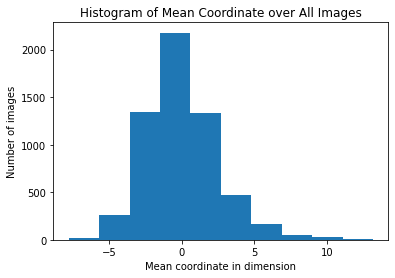

In [16]:
means = np.mean(reducedData, axis = 1)
plt.hist(means)
plt.xlabel("Mean coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Coordinate over All Images")
plt.show()

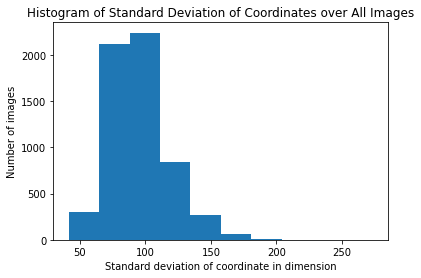

In [17]:
stds = np.std(reducedData, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation of coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Coordinates over All Images")
plt.show()

#### Unsupervised Model building

#### NMF

L2 Loss: three categories

In [18]:
# Finalize the predictions from NMF
def finalizePredictions(W):
    predictions = np.zeros(shape = (W.shape[0]))
    n_rows = W.shape[0]
    n_cols = W.shape[1]
    for i in range(n_rows):
        current_best = (None, 0)
        for j in range(n_cols):
            if W[i, j] > current_best[1]:
                current_best = (j, W[i, j])
        if current_best[0] == None:
            print("Something bad happened")    
        predictions[i] = current_best[0]
    return(predictions.astype(int))

# Label reconstructor
def reconstructLabels(pred, trueLabs):
    n = pred.shape[0]
    categories = list(np.unique(trueLabs))
    permutations = list(itertools.permutations(categories))
    currentBest = (None, float("inf"))
    for subset in permutations:
        n_misclassified = 0
        for i in range(n):
            if subset[int(pred[i])] != trueLabs[i]:
                n_misclassified = n_misclassified + 1
        if n_misclassified < currentBest[1]:
            currentBest = (subset, n_misclassified)
    return(currentBest)

In [19]:
# NMF model
nmf_model_1 = NMF(n_components = 3, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
W_1 = nmf_model_1.fit_transform(data)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [20]:
# Convert prediction
yhat1 = finalizePredictions(W_1)
categoryNames = reconstructLabels(yhat1, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [21]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat1))

[[1793   52  935]
 [1126  350  107]
 [1138   67  288]]


In [22]:
# Accuracy, precision, and recall
print("The L2 NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat1))
print("The L2 NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat1, average = "weighted"))
print("The L2 NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat1, average = "weighted"))

The L2 NMF with 3 categories had accuracy: 0.415129781420765
The L2 NMF with 3 categories had weighted average precision: 0.4667463436674939
The L2 NMF with 3 categories had weighted average recall: 0.415129781420765


L2 Loss: two categories

In [23]:
# NMF model
nmf_model_2 = NMF(n_components = 2, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
W_2 = nmf_model_2.fit_transform(data)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [24]:
# Convert predictions
yhat2 = finalizePredictions(W_2)
categoryNames = reconstructLabels(yhat2, labs2)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [25]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat2))

[[4131  142]
 [1515   68]]


In [26]:
# Accuracy, precision, and recall
print("The L2 NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat2))
print("The L2 NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat2, average = "weighted"))
print("The L2 NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat2, average = "weighted"))

The L2 NMF with 2 categories had accuracy: 0.7170423497267759
The L2 NMF with 2 categories had weighted average precision: 0.6214155927334378
The L2 NMF with 2 categories had weighted average recall: 0.7170423497267759


KL Loss: three categories

In [27]:
# NMF model
nmf_model_3 = NMF(n_components = 3, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
W_3 = nmf_model_3.fit_transform(data)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [28]:
# Convert predictions
yhat3 = finalizePredictions(W_3)
categoryNames = reconstructLabels(yhat3, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [29]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat3))

[[2643    2  135]
 [1560   15    8]
 [1456    2   35]]


In [30]:
# Accuracy, precision, and recall
print("The KL NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat3))
print("The KL NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat3, average = "weighted"))
print("The KL NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat3, average = "weighted"))

The KL NMF with 3 categories had accuracy: 0.459870218579235
The KL NMF with 3 categories had weighted average precision: 0.4852605186637412
The KL NMF with 3 categories had weighted average recall: 0.459870218579235


KL Loss: two categories

In [31]:
# NMF model
nmf_model_4 = NMF(n_components = 2, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
W_4 = nmf_model_4.fit_transform(data)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [32]:
# Convert predictions
yhat4 = finalizePredictions(W_4)
categoryNames = reconstructLabels(yhat4, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [33]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat4))

[[4211   62]
 [1564   19]]


In [34]:
# Accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat4))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat4, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat4, average = "weighted"))

The KL NMF with 2 categories had accuracy: 0.7223360655737705
The KL NMF with 2 categories had weighted average precision: 0.5954741118356783
The KL NMF with 2 categories had weighted average recall: 0.7223360655737705


#### K-Means

Lloyd: three categories

In [35]:
# K-Means model
lloyd = KMeans(n_clusters = 3, random_state = 42, max_iter = 100, algorithm = "full")
lloydModel = lloyd.fit_transform(reducedData)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [36]:
# Convert predictions
yhat5 = finalizePredictions(lloydModel)
categoryNames = reconstructLabels(yhat5, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [37]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat5))

[[1488 1260   32]
 [ 671  906    6]
 [ 626  850   17]]


In [38]:
# Accuracy, precision, and recall
print("The Lloyd KMeans with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat5))
print("The Lloyd KMeans with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat5, average = "weighted"))
print("The Lloyd KMeans with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat5, average = "weighted"))

The Lloyd KMeans with 3 categories had accuracy: 0.41171448087431695
The Lloyd KMeans with 3 categories had weighted average precision: 0.41364943884947114
The Lloyd KMeans with 3 categories had weighted average recall: 0.41171448087431695


Lloyd: two categories

In [39]:
# K-Means model
lloyd2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 100, algorithm = "full")
lloydModel2 = lloyd2.fit_transform(reducedData)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [40]:
# Convert predictions
yhat6 = finalizePredictions(lloydModel2)
categoryNames = reconstructLabels(yhat6, labs2)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [41]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat6))

[[ 825  758]
 [2006 2267]]


In [42]:
# Accuracy, precision, and recall
print("The Lloyd KMeans with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat6))
print("The Lloyd KMeans with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat6, average = "weighted"))
print("The Lloyd KMeans with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat6, average = "weighted"))

The Lloyd KMeans with 2 categories had accuracy: 0.5280054644808743
The Lloyd KMeans with 2 categories had weighted average precision: 0.6256130931833802
The Lloyd KMeans with 2 categories had weighted average recall: 0.5280054644808743


Elkan: three categories

In [43]:
# Elkan K-Means model
elkan = KMeans(n_clusters = 3, random_state = 42, max_iter = 1000, algorithm = "elkan")
elkanModel = elkan.fit_transform(reducedData)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [44]:
# Convert predictions
yhat7 = finalizePredictions(elkanModel)
categoryNames = reconstructLabels(yhat7, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [45]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat7))

[[1488 1260   32]
 [ 671  906    6]
 [ 626  850   17]]


In [46]:
# Accuracy, precision, and recall
print("The Elkan KMeans with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat7))
print("The Elkan KMeans with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat7, average = "weighted"))
print("The Elkan KMeans with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat7, average = "weighted"))

The Elkan KMeans with 3 categories had accuracy: 0.41171448087431695
The Elkan KMeans with 3 categories had weighted average precision: 0.41364943884947114
The Elkan KMeans with 3 categories had weighted average recall: 0.41171448087431695


Elkan: two categories

In [47]:
# Elkan K-Means model
elkan2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 1000, algorithm = "elkan")
elkanModel2 = elkan2.fit_transform(reducedData)

c:\Users\Admin\anaconda3\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [48]:
# Convert predictions
yhat8 = finalizePredictions(elkanModel2)
categoryNames = reconstructLabels(yhat8, labs2)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [49]:
# Confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat8))

[[ 825  758]
 [2006 2267]]


In [50]:
# Accuracy, precision, and recall
print("The Elkan KMeans with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat8))
print("The Elkan KMeans with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat8, average = "weighted"))
print("The Elkan KMeans with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat8, average = "weighted"))

The Elkan KMeans with 2 categories had accuracy: 0.5280054644808743
The Elkan KMeans with 2 categories had weighted average precision: 0.6256130931833802
The Elkan KMeans with 2 categories had weighted average recall: 0.5280054644808743


#### Unsupervised Learning Problem:

The confusion matrices generated by the Elkan and Lloyd algorithms are almost identical, indicating that KMeans has identified genuine categories present in the chest X-Rays. These categories could be related to patient size, shape, bone structure, race, etc. To determine what these clusters represent, we would need to apply these labels to a variety of different labeled training data. 
This is why Unsupervised Learning is intended to discover hidden patterns that the data analyst did not anticipate! Nonetheless, the models do exhibit some predictive capability for pneumonia, indicating that whatever clusters are being discovered are at least correlated with pneumonia

#### Compare with supervised model

Three categories

In [51]:
n_train = 5232
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs[:5232])
yhat9 = forest.predict(reducedData[5232: , :])

In [52]:
print(confusion_matrix(y_true = labs[5232: ], y_pred = yhat9))

[[234   8   0]
 [119 115   0]
 [130  12   6]]


In [53]:
# Accuracy, precision, and recall
print("The Random Forest with 3 categories had accuracy:" , accuracy_score(y_true = labs[5232: ], y_pred = yhat9))
print("The Random Forest with 3 categories had weighted average precision:", precision_score(y_true = labs[5232: ], y_pred = yhat9, average = "weighted"))
print("The Random Forest with 3 categories had weighted average recall:", recall_score(y_true = labs[5232: ], y_pred = yhat9, average = "weighted"))

The Random Forest with 3 categories had accuracy: 0.5689102564102564
The Random Forest with 3 categories had weighted average precision: 0.7445121303816956
The Random Forest with 3 categories had weighted average recall: 0.5689102564102564


Two categories

In [55]:
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs2[:5232])
yhat10 = forest.predict(reducedData[5232: , :])

In [56]:
print(confusion_matrix(y_true = labs2[5232: ], y_pred = yhat10))

[[384   6]
 [197  37]]


In [57]:
# Accuracy, precision, and recall
print("The Random Forest with 2 categories had accuracy:" , accuracy_score(y_true = labs2[5232: ], y_pred = yhat10))
print("The Random Forest with 2 categories had weighted average precision:", precision_score(y_true = labs2[5232: ], y_pred = yhat10, average = "weighted"))
print("The Random Forest with 2 categories had weighted average recall:", recall_score(y_true = labs2[5232: ], y_pred = yhat10, average = "weighted"))

The Random Forest with 2 categories had accuracy: 0.6746794871794872
The Random Forest with 2 categories had weighted average precision: 0.7357553136132571
The Random Forest with 2 categories had weighted average recall: 0.6746794871794872


In [58]:
# Correlation matrix to compare the similarity in predictions for three category models
yhatAll3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0]),
    yhat7.reshape(1, yhat7.shape[0]))
)

cosineMatrix = cosine_similarity(yhatAll3Categories)
print(.5 + .5 * cosineMatrix)

[[1.         0.67743219 0.79319435 0.79319435]
 [0.67743219 1.         0.587775   0.587775  ]
 [0.79319435 0.587775   1.         1.        ]
 [0.79319435 0.587775   1.         1.        ]]


If there was no correlation between any two clusters, a similarity metric of 0.333 would be expected since there are three categories. However, the correlations observed were much higher, indicating that all models had something in common. Therefore, we may consider combining the models and using the consensus opinion. Since models 5 and 7 (the K-Means models) had a perfect correlation, we need to exclude one for the combination to work. Now let's test this and see how it impacts accuracy:

In [65]:
yhatMost3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0])
))

def majorityRule3(predictionMatrix):
    baggedPred = np.zeros(predictionMatrix.shape[1]).astype(int)
    for j in range(predictionMatrix.shape[1]):
        counts = {
            0: 0,
            1: 0,
            2: 0
        }
        for i in range(predictionMatrix.shape[0]):
            this_prediction = predictionMatrix[i, j]
            counts.update({this_prediction : counts[this_prediction] + 1})
        if counts[0] > counts[1] and counts[0] > counts[2]:
            baggedPred[j] = 0
        elif counts[1] > counts[0] and counts[1] > counts[2]:
            baggedPred[j] = 1
        elif counts[2] > counts[0] and counts[2] > counts[1]:
            baggedPred[j] = 2
        else:
            tieBreaker = random.random()
            if counts[0] == counts[1] and counts[0] > counts[2]:
                assert counts[1] > counts[2]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 1
            elif counts[0] == counts[2] and counts[0] > counts[1]:
                assert counts[2] > counts[1]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 2
            elif counts[1] == counts[2] and counts[1] > counts[0]:
                assert counts[2] > counts[0]
                if tieBreaker < .5:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2
            else:
                assert counts[1] == counts[2] and counts[2] == counts[0]
                if tieBreaker < 1/3:
                    baggedPred[j] = 0
                elif tieBreaker < 2/3:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2
    return (baggedPred)

In [66]:
# Get bagged predictions
yhatBagged3 = majorityRule3(yhatMost3Categories)

# Convert labels 
categoryNames = reconstructLabels(yhatBagged3, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

print(confusion_matrix(y_true = newlabs, y_pred = yhatBagged3))

# Accuracy, precision, and recall
print("The Bagged Model with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhatBagged3))
print("The Bagged Model with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))
print("The Bagged Model with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))

[[2183  244  353]
 [1198  346   39]
 [1263  120  110]]
The Bagged Model with 3 categories had accuracy: 0.45064890710382516
The Bagged Model with 3 categories had weighted average precision: 0.41075422750001256
The Bagged Model with 3 categories had weighted average recall: 0.45064890710382516


The bagged model showed a slight improvement in metrics compared to the L2-Loss NMF and K-Means models, but still performed worse than the KL-Loss NMF. It appears that the L2-Loss NMF and K-Means models identified some clusters in the data that were consistently different from pneumonia status, whereas the KL-Loss NMF recognized more pneumonia. Consequently, the bagged model interfered destructively with itself, leading to a slight decrease in metrics.

It is important to note that the supervised model (which is the benchmark for predicting labels) also performed poorly, despite having a lengthy training period. Both the L2-Loss NMF and K2-Loss NMF outperformed the Random Forest in accuracy and recall for 2 category classification, but their precision was significantly worse. The poor performance of all models indicates two key points: (1) Detecting pneumonia in X-Rays is inherently challenging, which is why it necessitates medical expertise. (2) 5000 images are insufficient for teaching a machine how to read a chest X-Ray for pneumonia detection. Therefore, I would like to repeat the experiment with an additional order of magnitude of data.

#### Summary results for the three categories models:

| 3 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.4151   | 0.4667    | 0.4151 |
| KL-Loss NMF   | 0.4600   | 0.4847    | 0.4600 |
| Lloyd KMeans  | 0.4136   | 0.4136    | 0.4117 |
| Elkan KMeans  | 0.4117   | 0.4136    | 0.4117 |
| Bagged        | 0.4558   | 0.4170    | 0.4558 |
| Random Forest | 0.5689   | 0.7445    | 0.5689 |

#### Summary results for the two categories models:

| 2 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.7170   | 0.6214    | 0.7170 |
| KL-Loss NMF   | 0.7222   | 0.5947    | 0.7222 |
| Lloyd KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Elkan KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Random Forest | 0.6746   | 0.7358    | 0.6747 |

#### Conclusion
One way to potentially improve the unsupervised models is to extract the lungs from the rest of the body in the X-rays before inputting the data into the models. However, implementing this would require additional supervised models that can differentiate between the lungs and other body parts. This could be a promising topic for a master's thesis project.

After experimented with eight unsupervised learning models and developed custom functions to reconstruct labels and understand the clusters the algorithms generated. Although the models consistently produced similar clusterings, it is unclear what these clusters represent if not pneumonia. It is possible that the clusters could relate to variables such as sex, bone damage, or age groups, among others. This project highlights the fact that unsupervised models are designed to uncover trends that may not be apparent to data analysts, and it is up to the analyst to interpret and understand the resulting clusters.